https://www.unav.edu/web/instituto-de-ciencia-de-los-datos-e-inteligencia-artificial<br>

Autor: Darian Horacio Grass Boada

### ¿Qué es una Red Convolutiva de Grafos?

- Una arquitectura de red neuronal muy potente para el aprendizaje automático en grafos.
- Veamos un ejemplo básico y entendamos el funamento matemático subyacente con un ejemplo simple


Formalmente, una red convolutiva de grafos (GCN) es una red neuronal que opera en grafos. Dado un grafo $G = (V, E)$, una GCN toma como entrada
- una matriz de características de entrada $N \times F^{0}$, $X$, donde $N$ es el número de nodos y $F^{0}$ es el número de características de entrada para cada nodo, y
- una representación matricial $N \times N$ de la estructura del grafo, como la matriz de adyacencia $A$ de $G$

Por lo tanto, una capa oculta en la GCN se puede escribir como $H^{i} = f(H^{i-1},A)$ donde $H^{0} = X$ y $f$ es una regla de propagación
- Cada capa $H^{i}$ corresponde a una matriz de características $N \times F^{i}$ donde cada fila es una representación de características de un nodo.
- En cada capa, estas características se agregan para formar las características de la siguiente capa utilizando la regla de propagación $f$.

### Una Regla de Propagación Simple

Una de las reglas de propagación más simples posibles es:

$$f(H^{i}, A) = \sigma(AH^{i}W^{i}) $$

donde $W^{i}$ es la matriz de pesos para la capa $i$ y $\sigma$ es una función de activación no lineal como la función ReLU. La matriz de pesos tiene dimensiones $F^{i} \times F^{i+1}$; en otras palabras, el tamaño de la segunda dimensión de la matriz de pesos determina el número de características en la siguiente capa.


##### representación de matriz de adyacencia numpy

In [1]:
import numpy as np
A = np.matrix([
    [0, 1, 0, 0],
    [0, 0, 1, 1],
    [0, 1, 0, 0],
    [1, 0, 1, 0]],
    dtype=float
)
A

matrix([[0., 1., 0., 0.],
        [0., 0., 1., 1.],
        [0., 1., 0., 0.],
        [1., 0., 1., 0.]])

In [2]:
# Comprobar si la matriz es simétrica
def es_dirigido(A):
    return not np.array_equal(A, A.T)

if es_dirigido(A):
    print("El grafo es dirigido.")
else:
    print("El grafo no es dirigido.")

El grafo es dirigido.


##### ¡Necesitamos características! Generamos 2 características enteras para cada nodo basadas en su índice.

In [3]:
X = np.matrix([[i, -i] for i in range(A.shape[0])], dtype=float)
X

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.]])

##### Aplicando la Regla de Propagación

In [4]:
A*X

matrix([[ 1., -1.],
        [ 5., -5.],
        [ 1., -1.],
        [ 2., -2.]])

- ¿Qué pasó? ¡La representación de cada nodo (cada fila) es ahora una suma de las características de sus vecinos! En otras palabras, la capa convolutiva del grafo representa cada nodo como un agregado de su vecindario.

- Te animo a que compruebes el cálculo por ti mismo.

### Problemas ###
1. ¡La representación agregada de un nodo no incluye sus propias características!
2. Los nodos con grados grandes tendrán valores grandes en su representación de características, mientras que los nodos con grados pequeños tendrán valores pequeños.

### Problema 1: solución ###
##### Añadiendo Bucles Propios: En la práctica, esto se hace añadiendo la matriz identidad $I$ a la matriz de adyacencia $A$ antes de aplicar la regla de propagación.

In [5]:
I = np.matrix(np.eye(A.shape[0]))
I

matrix([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [6]:
A_hat = A + I
A_hat * X

matrix([[ 1., -1.],
        [ 6., -6.],
        [ 3., -3.],
        [ 5., -5.]])

In [7]:
A*X

matrix([[ 1., -1.],
        [ 5., -5.],
        [ 1., -1.],
        [ 2., -2.]])

- ¿Qué pasó con $v_{0}$?

### Problema 2: solución ###
##### Las representaciones de características pueden ser normalizadas por el grado del nodo transformando la matriz de adyacencia $A$ multiplicándola con la matriz de grado inversa $D$
$f(X,A)=D^{-1}AX$

##### Primero calculamos la matriz de grados.

In [8]:
D = np.array(np.sum(A, axis=0))[0]
D = np.matrix(np.diag(D))
D

matrix([[1., 0., 0., 0.],
        [0., 2., 0., 0.],
        [0., 0., 2., 0.],
        [0., 0., 0., 1.]])

In [9]:
A

matrix([[0., 1., 0., 0.],
        [0., 0., 1., 1.],
        [0., 1., 0., 0.],
        [1., 0., 1., 0.]])

##### veamos qué le sucede a la matriz de adyacencia después de transformarla.

In [10]:
D**-1 * A

matrix([[0. , 1. , 0. , 0. ],
        [0. , 0. , 0.5, 0.5],
        [0. , 0.5, 0. , 0. ],
        [1. , 0. , 1. , 0. ]])

- Observa que los valores en cada fila de la matriz de adyacencia han sido divididos por el grado del nodo correspondiente a la fila

##### Aplicamos la regla de propagación con la matriz de adyacencia transformada

In [11]:
D**-1 * A * X

matrix([[ 1. , -1. ],
        [ 2.5, -2.5],
        [ 0.5, -0.5],
        [ 2. , -2. ]])

- representaciones de nodos correspondientes a la media de las características de los nodos vecinos.
- esto se debe a que los pesos en la matriz de adyacencia (transformada) corresponden a pesos en una suma ponderada de las características de los nodos vecinos.

### Juntándolo Todo

> Ahora combinamos los consejos de bucle propio y normalización. Además, reintroduciremos los pesos y la función de activación

In [12]:
D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.matrix(np.diag(D_hat))
D_hat

matrix([[2., 0., 0., 0.],
        [0., 3., 0., 0.],
        [0., 0., 3., 0.],
        [0., 0., 0., 2.]])

- Añadiendo de nuevo los Pesos
- La primera tarea es aplicar los pesos.
- Nota que aquí D_hat es la matriz de grados de A_hat = A + I, es decir, la matriz de grados de A con bucles propios forzados.

In [13]:
W = np.matrix([[1, -1], [-1, 1]])
D_hat**-1 * A_hat * X * W

matrix([[ 1., -1.],
        [ 4., -4.],
        [ 2., -2.],
        [ 5., -5.]])

> si queremos reducir la dimensionalidad de las representaciones de características de salida, podemos reducir el tamaño de la matriz de pesos $W$

In [14]:
W = np.matrix([[1], [-1]])
D_hat**-1 * A_hat * X * W

matrix([[1.],
        [4.],
        [2.],
        [5.]])

In [15]:
def relu(x):
    return (np.maximum(0.0, x))


- Añadiendo una Función de Activación
- Elegimos preservar la dimensionalidad de las representaciones de características y aplicar la función de activación ReLU.

In [16]:
W = np.matrix([[1, -1], [-1, 1]])
relu(D_hat**-1 * A_hat * X * W)

matrix([[1., 0.],
        [4., 0.],
        [2., 0.],
        [5., 0.]])

> Hecho: ¡Una capa oculta completa con matriz de adyacencia, características de entrada, pesos y función de activación!

## Zachary’s Karate Club
### Construyendo la GCN

In [17]:
import networkx as nx

zkc = nx.karate_club_graph()
order = sorted(list(zkc.nodes()))

bb = nx.edge_betweenness_centrality(zkc, normalized=False)
nx.set_edge_attributes(zkc, bb, "weight")
zkc[0][1]["weight"]

14.166666666666664

In [18]:
A = nx.to_numpy_array(zkc, nodelist=order, weight='None')
I = np.eye(zkc.number_of_nodes())
A_hat = A + I
D_hat = np.array(np.sum(A_hat, axis=0))
D_hat = np.matrix(np.diag(D_hat))
D_hat

matrix([[17.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0., 10.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0., 11., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  7.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0., 13.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0., 18.]])

In [19]:
W_1 = np.random.normal(
    loc=0, scale=1, size=(zkc.number_of_nodes(), 4))
W_2 = np.random.normal(
    loc=0, size=(W_1.shape[1], 2))

In [20]:
def gcn_layer(A_hat, D_hat, X, W):
    return relu(D_hat**-1 * A_hat * X * W)
H_1 = gcn_layer(A_hat, D_hat, I, W_1)
H_2 = gcn_layer(A_hat, D_hat, H_1, W_2)
output = H_2
output

matrix([[0.66127054, 0.38632506],
        [0.48363299, 0.78096927],
        [0.152581  , 0.8012636 ],
        [0.50353757, 0.69345161],
        [0.65266493, 0.        ],
        [0.66241193, 0.        ],
        [0.56250954, 0.        ],
        [0.39135945, 0.72228937],
        [0.        , 0.5457062 ],
        [0.        , 0.858378  ],
        [0.6494017 , 0.0829738 ],
        [1.25374266, 0.        ],
        [0.61940232, 0.40629178],
        [0.23759634, 0.66645798],
        [0.        , 0.27420318],
        [0.        , 0.80615371],
        [0.66544484, 0.        ],
        [0.4711788 , 0.72475201],
        [0.        , 0.26859104],
        [0.26687689, 0.54896231],
        [0.        , 0.25865556],
        [0.5170869 , 0.6937139 ],
        [0.        , 0.41013029],
        [0.16753423, 0.84337645],
        [0.29793349, 1.14453626],
        [0.17632616, 1.04502296],
        [0.03192433, 0.21301113],
        [0.14511564, 0.78236862],
        [0.        , 0.49713015],
        [0.   

In [21]:
feature_representations = {
    node: np.array(output)[node]
    for node in zkc.nodes()}
feature_representations

{0: array([0.66127054, 0.38632506]),
 1: array([0.48363299, 0.78096927]),
 2: array([0.152581 , 0.8012636]),
 3: array([0.50353757, 0.69345161]),
 4: array([0.65266493, 0.        ]),
 5: array([0.66241193, 0.        ]),
 6: array([0.56250954, 0.        ]),
 7: array([0.39135945, 0.72228937]),
 8: array([0.       , 0.5457062]),
 9: array([0.      , 0.858378]),
 10: array([0.6494017, 0.0829738]),
 11: array([1.25374266, 0.        ]),
 12: array([0.61940232, 0.40629178]),
 13: array([0.23759634, 0.66645798]),
 14: array([0.        , 0.27420318]),
 15: array([0.        , 0.80615371]),
 16: array([0.66544484, 0.        ]),
 17: array([0.4711788 , 0.72475201]),
 18: array([0.        , 0.26859104]),
 19: array([0.26687689, 0.54896231]),
 20: array([0.        , 0.25865556]),
 21: array([0.5170869, 0.6937139]),
 22: array([0.        , 0.41013029]),
 23: array([0.16753423, 0.84337645]),
 24: array([0.29793349, 1.14453626]),
 25: array([0.17632616, 1.04502296]),
 26: array([0.03192433, 0.21301113

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

X = []
Y = []
C = []
Id = []
for item in feature_representations:
    X.append(feature_representations[item][0])
    Y.append(feature_representations[item][1])
    C.append(zkc.nodes[item]["club"])
    Id.append(item)


#create DataFrame
df = pd.DataFrame({'x': X,
                   'y': Y,
                   'id': Id,
                   'z': C
                   })

df

,x,y,id,z
0,0.661271,0.386325,0,Mr. Hi
1,0.483633,0.780969,1,Mr. Hi
2,0.152581,0.801264,2,Mr. Hi
3,0.503538,0.693452,3,Mr. Hi
4,0.652665,0.000000,4,Mr. Hi
5,0.662412,0.000000,5,Mr. Hi
6,0.562510,0.000000,6,Mr. Hi
7,0.391359,0.722289,7,Mr. Hi
8,0.000000,0.545706,8,Mr. Hi
9,0.000000,0.858378,9,Officer


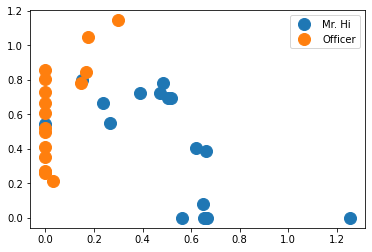

In [23]:
groups = df.groupby('z')
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=12, label=name)
    # plt.text(group.x, group.y, group.id)

plt.legend()